In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('95c03c589c246cc7b67e5f91944f5fc4/2087604_42.79_-78.40_2007.csv',header=1)

df_1 = pd.read_csv('95c03c589c246cc7b67e5f91944f5fc4/2087604_42.79_-78.40_2008.csv',header=1).drop(labels=range(720,8760),axis=0)
df = pd.concat([df,df_1],axis=0,ignore_index=True)
print(df.columns)
print(len(df))
#print the head
df.head()

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'power - DEPRECATED',
       'wind direction at 100m (deg)', 'wind speed at 100m (m/s)',
       'air temperature at 100m (C)', 'air pressure at 100m (Pa)',
       'density - DEPRECATED', 'Date'],
      dtype='object')
9480


,Year,Month,Day,Hour,Minute,power - DEPRECATED,wind direction at 100m (deg),wind speed at 100m (m/s),air temperature at 100m (C),air pressure at 100m (Pa),density - DEPRECATED,Date
0,2007,1,1,0,30,NaN,179.54,19.34,6.94,95010,NaN,1/1/07 00:00
1,2007,1,1,1,30,NaN,181.62,18.22,7.14,95030,NaN,1/1/07 01:00
2,2007,1,1,2,30,NaN,185.42,17.50,7.05,95060,NaN,1/1/07 02:00
3,2007,1,1,3,30,NaN,186.44,17.26,7.41,95030,NaN,1/1/07 03:00
4,2007,1,1,4,30,NaN,188.46,15.05,7.24,95030,NaN,1/1/07 04:00


In [19]:
##importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras
import time

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'wind speed at 100m (m/s)'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['wind speed at 100m (m/s)'][i] = data['wind speed at 100m (m/s)'][i]


#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:8760,:]
valid = dataset[8760:,:]


#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Generate an array of the different optimizers to iterate over in a for loop
act_names = ['relu','elu']

# Arrays for training and validation performance
hist_acc = []
hist_val_acc = []
hist_loss = []
hist_val_loss = []
pre = np.zeros([4,720])
time_list = []

# Iterate over optimizers and train the network, using x_test and y_test as a validation set in each epoch
for name in act_names:
    print("----------------------------------------------------------------------------------")
    print("Training the MLP ANN with %s activation function" %str(name))
    st_t = time.time()
    # predicting 720 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
        y_test.append(inputs[i,0])
    X_test,y_test = np.array(X_test), np.array(y_test)

#     X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    model = Sequential()
    model.add(Dense(20, activation=name,input_shape=(x_train.shape[1],)))
    model.add(Dense(10, activation=name))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['accuracy'])
    seqModel = model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2,validation_data=(X_test, y_test))
    
    # Store the performance
    print(seqModel.history.keys())
#     hist_acc.append(seqModel.history['accuracy'])
#     hist_val_acc.append(seqModel.history['val_accuracy'])
    hist_loss.append(seqModel.history['loss'])
    hist_val_loss.append(seqModel.history['val_loss'])
                         
    
    wind_speed = model.predict(X_test)
    wind_speed = scaler.inverse_transform(wind_speed)
    pre[act_names.index(name)] = wind_speed.reshape(1,-1)
    en_t = time.time()
    time_list.append((name,en_t-st_t))
    

----------------------------------------------------------------------------------
Training the MLP ANN with relu activation function
Epoch 1/100
8700/8700 - 9s - loss: 0.0063 - accuracy: 2.2989e-04 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 2/100
8700/8700 - 13s - loss: 0.0042 - accuracy: 2.2989e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 3/100
8700/8700 - 11s - loss: 0.0039 - accuracy: 2.2989e-04 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 4/100
8700/8700 - 8s - loss: 0.0037 - accuracy: 2.2989e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 5/100
8700/8700 - 9s - loss: 0.0036 - accuracy: 2.2989e-04 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 6/100
8700/8700 - 10s - loss: 0.0035 - accuracy: 2.2989e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 7/100
8700/8700 - 9s - loss: 0.0035 - accuracy: 2.2989e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 8/100
8700/8700 - 9s - loss: 0.0034 - accuracy: 2.2989e-04 - val_loss: 0.0028 - 

Epoch 73/100
8700/8700 - 9s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 74/100
8700/8700 - 7s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 75/100
8700/8700 - 7s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 76/100
8700/8700 - 7s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 77/100
8700/8700 - 9s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 78/100
8700/8700 - 5s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 79/100
8700/8700 - 6s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 80/100
8700/8700 - 5s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 81/100
8700/8700 - 7s - loss: 0.0030 - accuracy: 2.2989e-04 - val_loss: 0.0026 - val_accuracy: 0.0

Epoch 45/100
8700/8700 - 5s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 46/100
8700/8700 - 5s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 47/100
8700/8700 - 5s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 48/100
8700/8700 - 6s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 49/100
8700/8700 - 5s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 50/100
8700/8700 - 5s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 51/100
8700/8700 - 5s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 52/100
8700/8700 - 6s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 53/100
8700/8700 - 8s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0026 - val_accuracy: 0.0

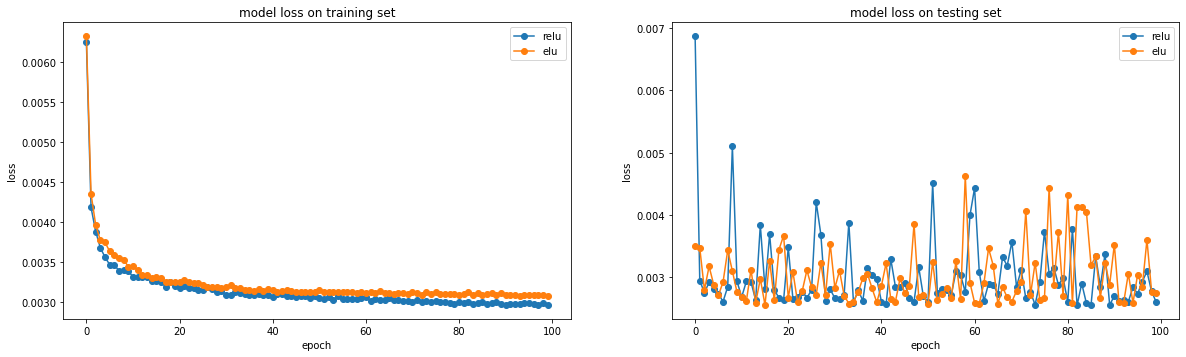

In [20]:
plt.figure(figsize=(20,12))

# # summarize history for accuracy on training set
# plt.subplot(221)
# for i in range(len(act_names)):
#     plt.plot(hist_acc[i],'-o',label=str(act_names[i]))
# plt.title('model accuracy on training set')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='lower right')

# # summarize history for accuracy on test set
# plt.subplot(222)
# for i in range(len(act_names)):
#     plt.plot(hist_val_acc[i],'-o', label=str(act_names[i]))
# plt.title('model accuracy on testing set')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='lower right')

# summarize history for loss on training set
plt.subplot(223)
for i in range(len(act_names)):
    plt.plot(hist_loss[i],'-o',label=str(act_names[i]))
plt.title('model loss on training set')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

# summarize history for loss on test set
plt.subplot(224)
for i in range(len(act_names)):
    plt.plot(hist_val_loss[i],'-o', label=str(act_names[i]))
plt.title('model loss on testing set')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.show()

<ipython-input-24-44d89b3040b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['relu'] = pre[0]
<ipython-input-24-44d89b3040b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['elu'] = pre[1]
<ipython-input-24-44d89b3040b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

([<matplotlib.axis.XTick at 0x7fa71a0c32e0>,
 <a list of 11 Text major ticklabel objects>)

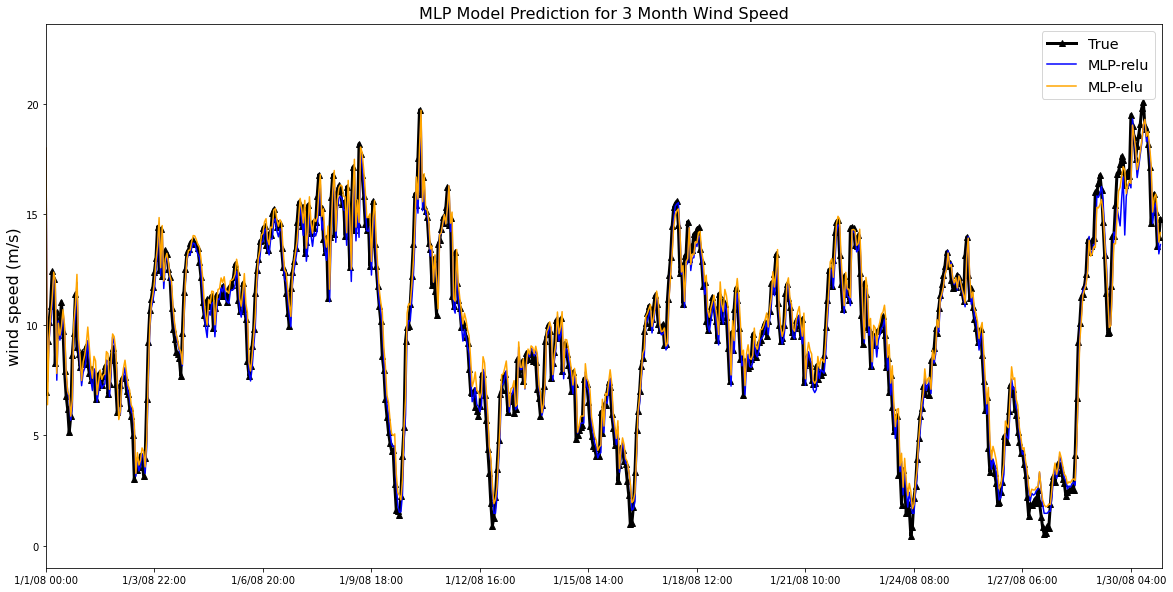

In [24]:
#for plotting
import datetime

train = new_data[:8760]
valid = new_data[8760:]
valid['relu'] = pre[0]
valid['elu'] = pre[1]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])

plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['relu'], label='MLP-relu',color='b')
plt.plot(valid['elu'], label='MLP-elu',color='orange')
plt.title('MLP Model Prediction for 3 Month Wind Speed',fontsize=16)
plt.ylabel('wind speed (m/s)',fontsize=16)

plt.legend(fontsize='x-large')
plt.xlim(8760,9480)
plt.xticks(np.arange(8760,9480, 70))

<ipython-input-29-f23d8d4f443d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['relu'] = pre[0]
<ipython-input-29-f23d8d4f443d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['elu'] = pre[1]
<ipython-input-29-f23d8d4f443d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

([<matplotlib.axis.XTick at 0x7fa70009be50>,
 <a list of 9 Text major ticklabel objects>)

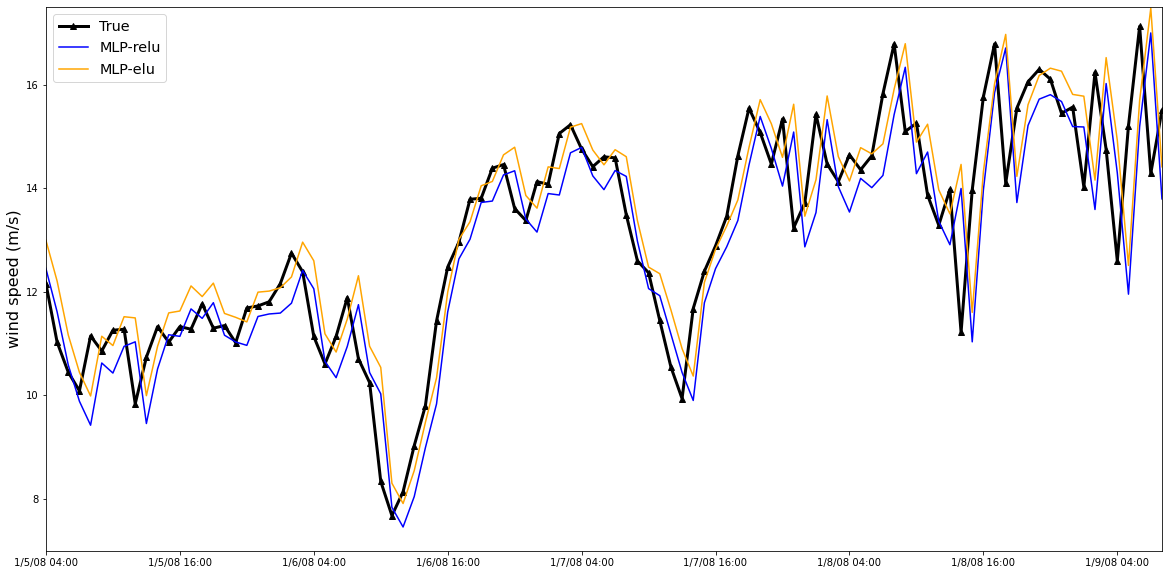

In [29]:
#for plotting
import datetime

train = new_data[:8760]
valid = new_data[8760:]
valid['relu'] = pre[0]
valid['elu'] = pre[1]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])

plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['relu'], label='MLP-relu',color='b')
plt.plot(valid['elu'], label='MLP-elu',color='orange')

plt.ylabel('wind speed (m/s)',fontsize=16)

plt.legend(fontsize='x-large')
plt.xlim(8860,8960)
plt.ylim(7,17.5)
plt.xticks(np.arange(8860,8960, 12))

<ipython-input-31-69838f068006>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['relu'] = pre[0]
<ipython-input-31-69838f068006>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['elu'] = pre[1]
<ipython-input-31-69838f068006>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

([<matplotlib.axis.XTick at 0x7fa700bc12e0>,
 <a list of 9 Text major ticklabel objects>)

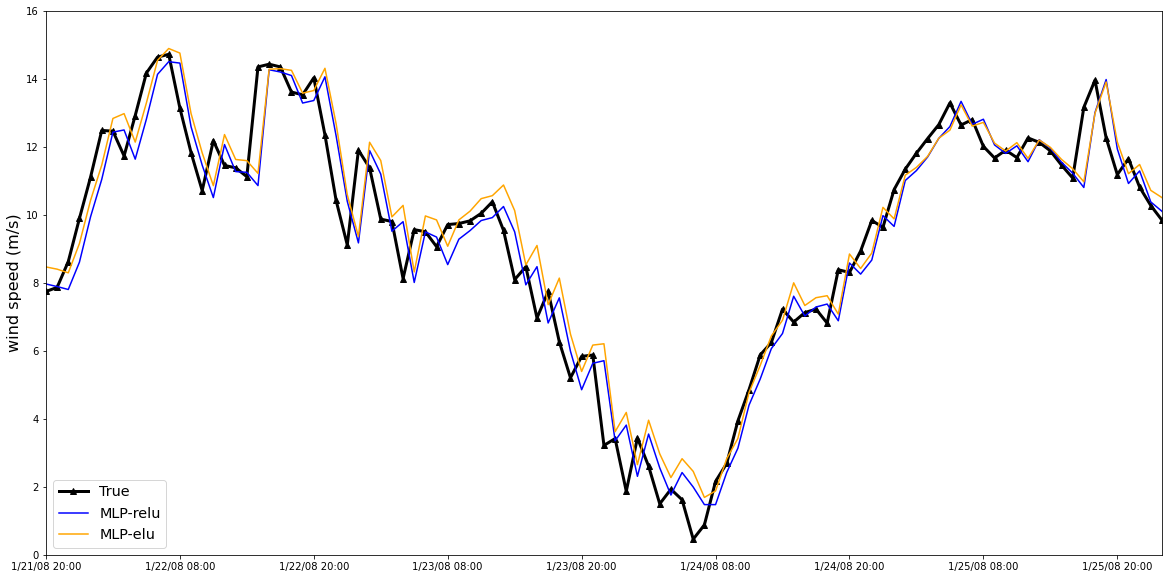

In [31]:
#for plotting
import datetime

train = new_data[:8760]
valid = new_data[8760:]
valid['relu'] = pre[0]
valid['elu'] = pre[1]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])

plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['relu'], label='MLP-relu',color='b')
plt.plot(valid['elu'], label='MLP-elu',color='orange')

plt.ylabel('wind speed (m/s)',fontsize=16)

plt.legend(fontsize='x-large')
plt.xlim(9260,9360)
plt.ylim(0,16)
plt.xticks(np.arange(9260,9360, 12))

In [32]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def bias_S(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(y_true-y_pred)/len(y_true)

In [34]:
from sklearn.metrics import mean_squared_error
true = valid['True'].to_numpy()
rmse_list = []
mape_list = []
bias_list = []
rmse_1 = mean_squared_error(true, pre[0],squared='False')
rmse_list.append(rmse_1)
rmse_2 = mean_squared_error(true, pre[1],squared='False')
rmse_list.append(rmse_2)


mape_1 = mean_absolute_percentage_error(true, pre[0])
mape_list.append(mape_1)
mape_2 = mean_absolute_percentage_error(true, pre[1])
mape_list.append(mape_2)


b_1 = bias_S(true, pre[0])
bias_list.append(b_1)
b_2 = bias_S(true, pre[1])
bias_list.append(b_2)


print(rmse_list)
print(mape_list)
print(bias_list)

[1.2977439732750553, 1.3752811038162096]
[12.316147635712744, 14.097491457066678]
[0.0691550040973557, -0.26602253072129345]


In [35]:
print(time_list)

[('relu', 675.5583648681641), ('elu', 759.524787902832)]
